Full pipeline for generating captions for Full Resolution Whole Slide Images (WSI).

The Pipeline is as follows:

1. Generate patches
2. Generate HIPT representations from these patches
3. Load pre-trained captioning model
4. Generate captions using in-built hugging face generate module

In [1]:
from transformers.utils import logging

logging.set_verbosity_error()
logger = logging.get_logger("transformers")

## 1. Generate patches

In [2]:
# adapted from CLAM: https://github.com/mahmoodlab/CLAM/
from gen_patch.create_patches_fp import patch_one_wsi

In [3]:
patch_size=4096
step_size=4096

wsi_full_path='/scratch/ss4yd/gtex_data/GTEX-13FLV-0326.svs'
save_dir='/home/ss4yd/nlp/full_inference_pipeline/image_files/'
slide_id = wsi_full_path.split('/')[-1].split('.')[0]
print(slide_id)

patch_one_wsi(wsi_full_path=wsi_full_path, save_dir=save_dir, 
              patch_size=patch_size, step_size=step_size)

GTEX-13FLV-0326
Creating patches for:  GTEX-13FLV-0326 ...
Total number of contours to process:  2
Bounding Box: 27699 3776 18836 19489
Contour Area: 268852696.0
Extracted 20 coordinates
Bounding Box: 3488 3136 18916 21169
Contour Area: 244157072.0
Extracted 20 coordinates
stitch
start stitching GTEX-13FLV-0326
original size: 49799 x 28049
downscaled size for stiching: 3112 x 1753
number of patches: 40
patch size: 4096x4096 patch level: 0
ref patch size: (4096, 4096)x(4096, 4096)
downscaled patch size: 256x256
progress: 0/40 stitched
progress: 4/40 stitched
progress: 8/40 stitched
progress: 12/40 stitched
progress: 16/40 stitched
progress: 20/40 stitched
progress: 24/40 stitched
progress: 28/40 stitched
progress: 32/40 stitched
progress: 36/40 stitched
segmentation took 4.243058919906616 seconds
patching took 0.20808172225952148 seconds
stitching took 0.3710141181945801 seconds


## 2. Generate HIPT representations from patches

Note that if CPU bound, extracting representations can take some time. If using GPU, this code only works if you have 2 cuda devices.

Here we have 2 NVIDIA A6000s and it takes around ~90 seconds to generate representations of size 256x384 for 46 4096x4096 patches created from the WSI from the ViT-256 and ViT-4096.

In [4]:
import torch
torch.cuda.get_device_name(0), torch.cuda.get_device_name(1)

('NVIDIA RTX A6000', 'NVIDIA RTX A6000')

In [5]:
# adapted from https://github.com/mahmoodlab/HIPT
from gen_reps.generate4k_256clsreps import generate4kreps_onewsi
import os

In [6]:
generate4kreps_onewsi(wsi_full_path, save_dir)

Take key teacher in provided checkpoint dict
Pretrained weights found at /home/ss4yd/vision_transformer/HIPT/HIPT_4K/Checkpoints/vit256_small_dino.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight_g', 'head.last_layer.weight_v'])
# of Patches: 196
Take key teacher in provided checkpoint dict
Pretrained weights found at /home/ss4yd/vision_transformer/HIPT/HIPT_4K/Checkpoints/vit4k_xs_dino.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight_g', 'head.last_layer.weight_v'])
SVS ID: GTEX-13FLV-0326
Number of patches: 40
Finished saving tensor..
generating reps took 87.46586227416992 seconds


## 3. Load pre-trained captioning model

In [7]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from model_files.model_vit_bert import ViTConfigCustom, ViTModelCustom, CustomVEDConfig, CustomVisionEncoderDecoder
from model_files.lightning_model import LightningModel
from tqdm import tqdm
import os
import torch

# models: Encoder    
encoder = ViTModelCustom(config=ViTConfigCustom(hidden_size=576), pretrain_4k='vit4k_xs_dino', freeze_4k=True)

# decoder
decoder_model_name="emilyalsentzer/Bio_ClinicalBERT"
decoder = AutoModelForCausalLM.from_pretrained(decoder_model_name, is_decoder=True, add_cross_attention=True)
tokenizer = AutoTokenizer.from_pretrained(decoder_model_name)

# encoder decoder model
model=CustomVisionEncoderDecoder(config=CustomVEDConfig(),encoder=encoder, decoder=decoder)
model.config.decoder_start_token_id = tokenizer.cls_token_id
model.config.pad_token_id = tokenizer.pad_token_id

lightning_model = LightningModel(model, tokenizer, model_lr=1e-2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ckpt="/scratch/ss4yd/logs_only_vit_bert_fe/my_model/version_5/checkpoints/epoch=5-val_loss=0.80-step=3720.00.ckpt"
lightning_model.load_state_dict(torch.load(ckpt,map_location=device)['state_dict'])
lightning_model=lightning_model.to(device)

# of Patches: 196
Loading Pretrained Local VIT model...
Done!
Freezing Pretrained Local VIT model
Done


## 4. Generate captions using in-built hugging face generate module

In [8]:
lightning_model.eval()
reps_path = os.path.join(save_dir, 'reps', f'{slide_id}.pt')

def generate_func(lm, reps_path, max_length=128, num_beams=2, do_sample=True):
    pixel_values=torch.load(reps_path).unsqueeze(0)
    pixel_values=pixel_values.to(device)
    gencap=lm.model.generate(pixel_values, max_length=max_length, num_beams=num_beams, do_sample=do_sample)

    decoded_cap=tokenizer.decode(gencap[0])
    remove_sptokens=decoded_cap[6:decoded_cap.find('[SEP]')]

    # print(f'Generated Note: \n {remove_sptokens}')

    return remove_sptokens

gen_note = generate_func(lightning_model, reps_path, num_beams=1, do_sample=False)
gen_note

/home/ss4yd/.local/lib/python3.9/site-packages/transformers/generation/utils.py:1255: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(


'this is a liver tissue from a male patient and it has 2 pieces, moderate passive congestion '

## 5. Visualize results

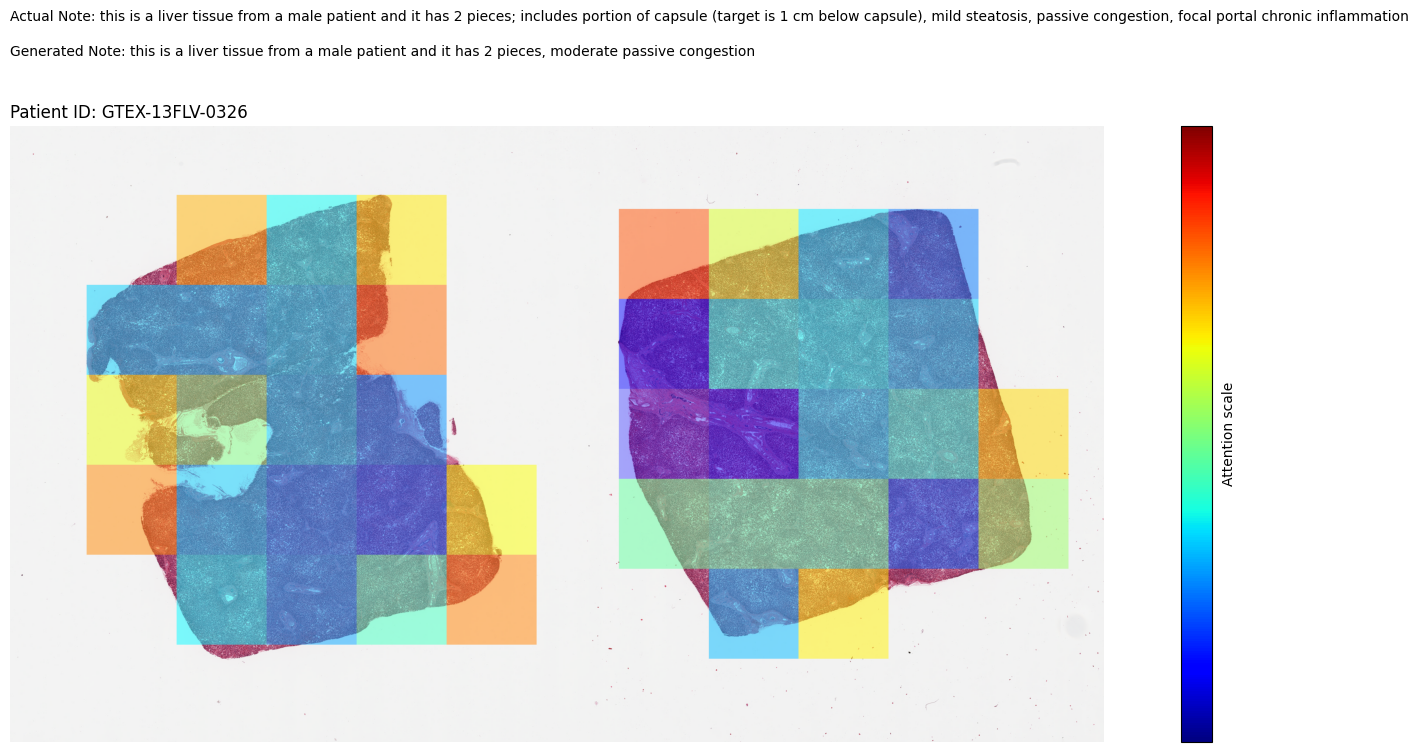

In [9]:
import pandas as pd
data=pd.read_csv('./data_files/GTExPortal.csv')

actual_note=data[data['Tissue Sample ID']==slide_id]['Pathology Notes']
actual_tt=data[data['Tissue Sample ID']==slide_id]['Tissue']
actual_gender=data[data['Tissue Sample ID']==slide_id]['Sex']

actual_text=f'this is a {actual_tt.item().lower()} tissue from a {actual_gender.item().lower()} patient and it has {actual_note.item().lower()}'

patch_path = os.path.join(save_dir, 'patches', f'{slide_id}.h5')

# create attn_viz save directory
os.makedirs(os.path.join(save_dir, 'attn_viz'), exist_ok=True)

with torch.no_grad():
    pixel_values=torch.load(reps_path).unsqueeze(0)
    attentions=lightning_model.model.encoder(pixel_values.to(device))['attentions'].cpu().numpy()[0,:]

from attn_visualization import gen_attn_viz
import matplotlib.pyplot as plt

sup_img=gen_attn_viz(wsi_full_path, patch_path, attentions)

plt.figure(figsize=(20,8))
plt.imshow(sup_img, cmap='jet')
plt.title(f'Patient ID: {slide_id}',loc='left')
plt.text(0, -300, f'Actual Note: {actual_text}', fontsize=10)
plt.text(0, -200, f'Generated Note: {gen_note}', fontsize=10)
plt.colorbar(label='Attention scale',ticks=[])
plt.axis('off')
plt.savefig(os.path.join(save_dir,'attn_viz', f'{slide_id}.png'), bbox_inches='tight')
plt.show()